In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2
)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup paths to our data directories
train_dir = "/kaggle/input/acne-split/Acne_ig/Acne_split/train"
test_dir = "/kaggle/input/acne-split/Acne_ig/Acne_split/val"

# Print directory contents
print("Train directory contents:", os.listdir(train_dir))
print("Validation directory contents:", os.listdir(test_dir))

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=16,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)
valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=16,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)

# Print the number of samples
print("Number of training samples:", train_data.samples)
print("Number of validation samples:", valid_data.samples)

Train directory contents: ['Level_0', 'Level_1', 'Level_2']
Validation directory contents: ['Level_0', 'Level_1', 'Level_2']
Found 967 images belonging to 3 classes.
Found 370 images belonging to 3 classes.
Number of training samples: 967
Number of validation samples: 370


# InceptionV3

In [5]:
# Load pre-trained InceptionV3 model
base_model = InceptionV3(
    weights=None,  # Initialize with no weights
    input_shape=(224, 224, 3),
    include_top=False
)

# Load weights from the downloaded .h5 file
base_model.load_weights("/kaggle/input/inceptionv3/inception_v3_weights_notop.h5")
# Add custom layers on top of InceptionV3
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

In [6]:
# Compile the model
model.compile(
    optimizer=Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Train the model
history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // 16,
    epochs=10,
    validation_data=valid_data,
    validation_steps=valid_data.samples // 16
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

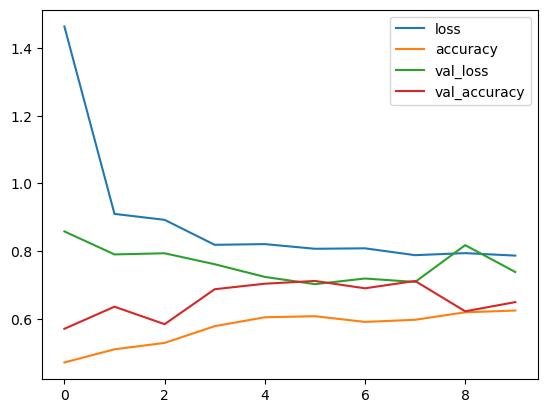

In [7]:
a = pd.DataFrame(model.history.history)
a.plot()
#plotting
import matplotlib.pyplot as plt
def display_training_curves(training, validation, title, subplot):

    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

/tmp/ipykernel_256/3644479810.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


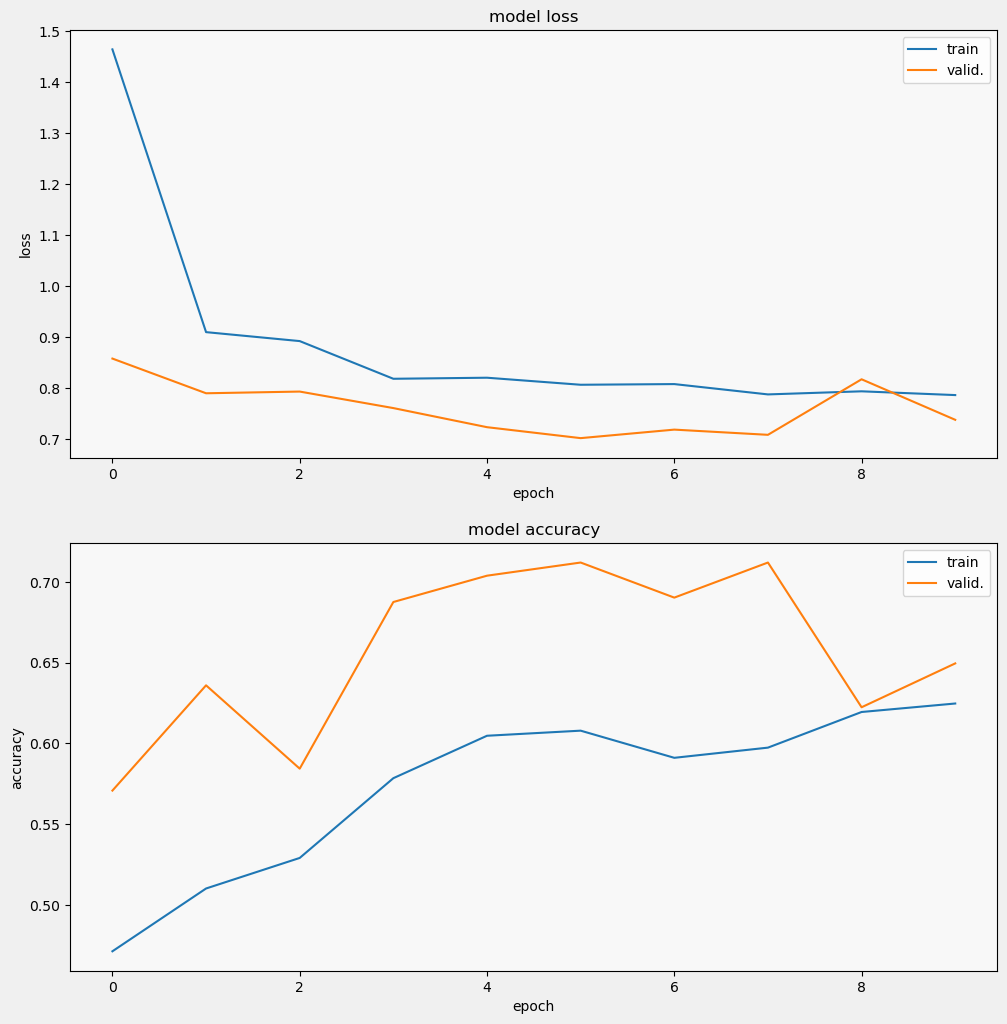

In [9]:
#display
display_training_curves(
    model.history.history['loss'],
    model.history.history['val_loss'],
    'loss', 211)
display_training_curves(
    model.history.history['accuracy'],
    model.history.history['val_accuracy'],
    'accuracy', 212)

1/1 [==============================] - 0s 92ms/step


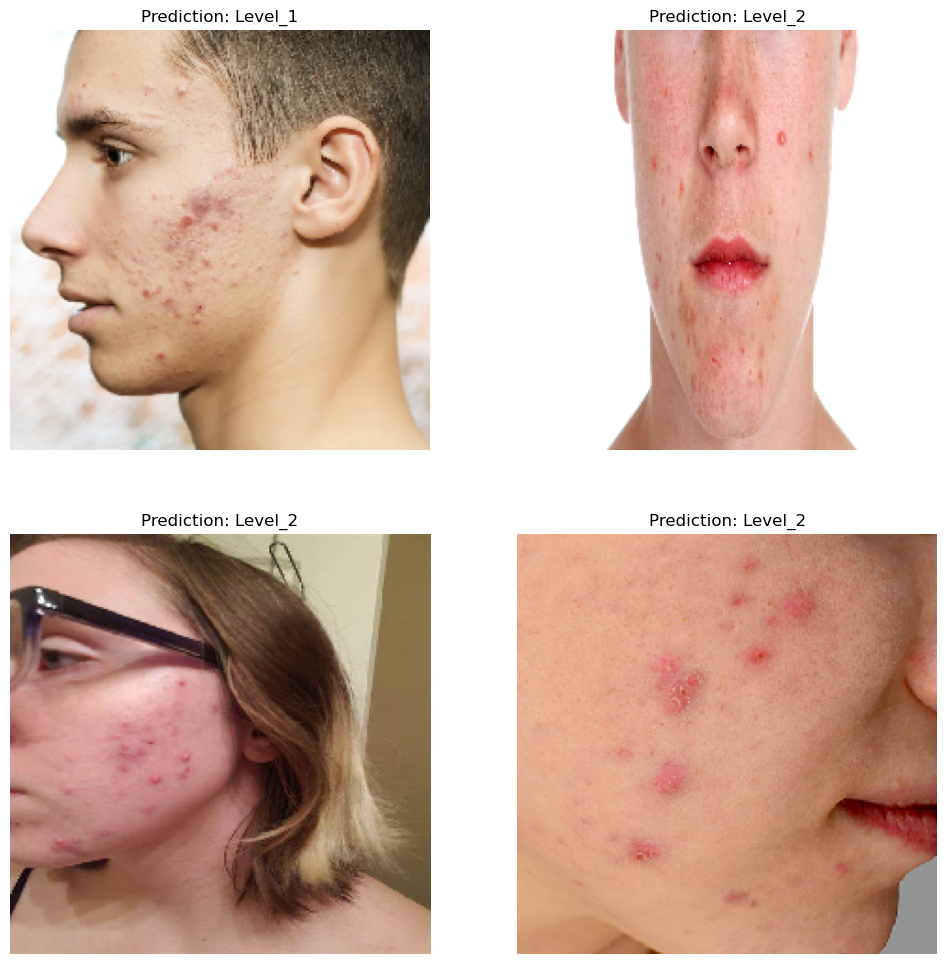

Image: acne.jpg - Prediction: Level_1
Image: R (2).jpg - Prediction: Level_2
Image: OIP (24).jpg - Prediction: Level_2
Image: 2 (1).png - Prediction: Level_2


In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)  # Load the image
    img_array = image.img_to_array(img)  # Convert the image to an array
    img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
    img_array /= 255.0  # Normalize if required
    return img_array

def predict_and_display_images(folder_path, n=4):
    predictions = []
    labels = train_data.class_indices
    labels = {v: k for k, v in labels.items()}

    # Counter for the number of predictions
    count = 0
    plt.figure(figsize=(12, 12))  # Set up the figure size for displaying images

    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)

        # Check if it's a valid image file
        if img_file.endswith('.jpg') or img_file.endswith('.png'):
            img_array = preprocess_image(img_path)
            
            # Predict
            pred = model.predict(img_array)
            
            # Get the class index with the highest probability
            pred_index = np.argmax(pred, axis=1)
            
            # Map the index to the class label
            pred_label = labels[pred_index[0]]
            
            # Store the prediction
            predictions.append((img_file, pred_label))

            # Display the image with its prediction
            img = image.load_img(img_path, target_size=(224, 224))
            plt.subplot(2, 2, count + 1)  # Plot in a 2x2 grid
            plt.imshow(img)
            plt.title(f'Prediction: {pred_label}')
            plt.axis('off')

            # Increment the counter
            count += 1
            
            # Stop after the first n predictions
            if count == n:
                break

    plt.show()  # Display the images

    return predictions

# Path to the folder containing images
folder_path = '/kaggle/input/acne-dataset/Acne'

# Predict and display the first 4 images in the folder
first_4_predictions = predict_and_display_images(folder_path, n=4)

# Optionally, print the first 4 predictions
for img_file, pred_label in first_4_predictions:
    print(f'Image: {img_file} - Prediction: {pred_label}')


In [22]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict the classes for the validation data
predictions = model.predict(valid_data)
y_pred = np.argmax(predictions, axis=1)

# Get true labels from the validation data generator
y_true = valid_data.classes

# Print classification report
class_names = list(valid_data.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names))

# Print confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_true, y_pred))


24/24 [==============================] - 21s 863ms/step
              precision    recall  f1-score   support

     Level_0       0.59      0.89      0.71       143
     Level_1       0.77      0.44      0.56       176
     Level_2       0.69      0.73      0.70        51

    accuracy                           0.65       370
   macro avg       0.68      0.68      0.66       370
weighted avg       0.69      0.65      0.64       370

Confusion Matrix
[[127  14   2]
 [ 84  77  15]
 [  5   9  37]]


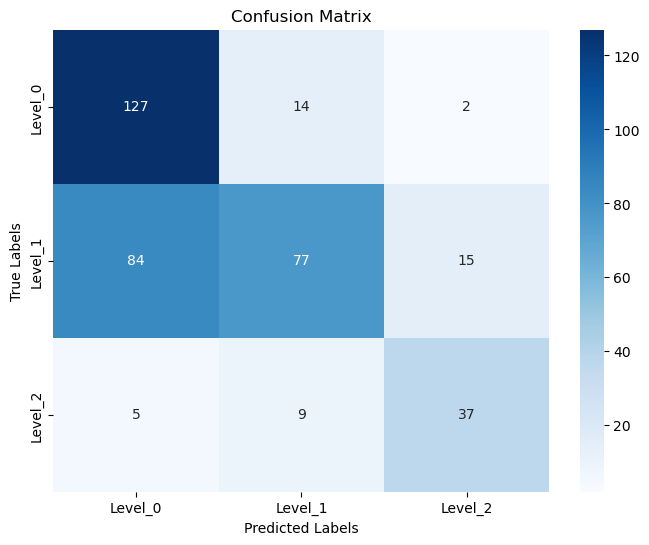

In [26]:
import seaborn as sns
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [27]:
# Save the trained model
model.save('acne_classification.h5')

# Print number of samples
print("Number of training samples:", train_data.samples)
print("Number of validation samples:", valid_data.samples)

Number of training samples: 967
Number of validation samples: 370
